# Analyse free text using Ehrapy and MedCat

This tutorial serves as an intro on how to use *Ehrapy* together with *MedCat*. *MedCat* (https://github.com/CogStack/MedCAT) is a tool to extract medical entities from free text and link it to biomedical ontologies. Biomedical entities could be anything biomedical; not only diagnoses or diseases but also symptoms, drugs or even peptides. 
It also tries to keep the context of an extracted entitiy (for example, whether a specific disease has been diagnosed or not). This is especially important in electronic health records data, as most of the time doctors notes are simply copied and pasted into the data and not preprocessed in any form. And even it is, it is very important to keep the context of an entity as this can be crucial to analysis. Consider the following example:

- The patient suffers from diabetes.

 vs.
 
- The patient does not suffer from diabetes.


In detail, Ehrapy uses a pretrained and packages model from MedCat (https://medcat.readthedocs.io/en/latest/main.html#models). This model has its limitations but it's good for now. A larger (trained) model is planned to be released somewhere in the (near) future by MedCat maintainers though.

In [1]:
import ehrapy as ep
import spacy
import pandas as pd

Installed version 0.2.0 of ehrapy is newer than the latest release 0.1.0! You are running a 
nightly version and features may break!

/home/thelichking/anaconda3/envs/new_ep_env/lib/python3.8/site-packages/medcat/cat.py:18: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


In [2]:
ep.settings.n_jobs=8

In [3]:
# !wget https://raw.githubusercontent.com/CogStack/MedCAT/master/tutorial/data/pt_notes.csv -P ./medcat_data/
# !wget https://medcat.rosalind.kcl.ac.uk/media/medmen_wstatus_2021_oct.zip -P ./medcat_data/

# Custom MedCAT object of Ehrapy

This is the entry point for every analysis using *Ehrapy* and *MedCat*. The data is read and after encoding and calculating nearest neighbors (which are just intermediate steps required for some tools and plots in ehrapy), the *Ehrapy* medcat object is created. 

This object keeps a reference to the actual *AnnData* object, but is also storing a few more *MedCat* related things like a *vocabulary*, a *concept database* and (later on in this tutorial) also the *annotated results*.

In [4]:
# read the example anndata object
adata = ep.io.read_csv("medcat_data/pt_notes.csv", columns_obs_only=["text"])
# encode the anndata object which is needed for later tools and plotting
adata_encoded = ep.pp.encode(adata, autodetect=True)
# calculate nearest neighbors for anndata object which is also used later in tools and plots
ep.pp.neighbors(adata_encoded)
# create the main ehrapy medcat object used for medical entitiy analysis using ehrapy and medcat
ep_medcat = ep.tl.MedCAT(adata_encoded, model_pack_path="./medcat_data/medmen_wstatus_2021_oct")
# only use diseases and behavioural disorders diagnoses in this example by filtering by tui
ep_medcat.set_filter_by_tui(tuis=["T047", "T048"])

Output()

/home/thelichking/Desktop/ehrapy/ehrapy/preprocessing/encoding/_encode.py:227: FutureWarning:
X.dtype being converted to np.float32 from object. In the next version of anndata (0.9) 
conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass 
`AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  encoded_ann_data = AnnData(

The CDB was exported by an unknown version of MedCAT.
{
  "Model ID": null,
  "Last Modifed On": null,
  "History (from least to most recent)": [],
  "Description": "No description",
  "Source Ontology": null,
  "Location": null,
  "MetaCAT models": {},
  "Basic CDB Stats": {},
  "Performance": {
    "ner": {},
    "meta": {}
  },
  "Important Parameters (Partial view, all available in cat.config)": {
    "config.ner['min_name_len']": {
      "value": 3,
      "description": "Minimum detection length (found terms/mentions shorter than this will not be detected)."
    },
    "config.ner['upper_case_limit_len']": {
      "value": 3,
      "description": "All detected terms shorter than this value have to be uppercase, otherwise they will be ignored."
    },
    "config.linking['similarity_threshold']": {
      "value": 0.2,
      "description": "If the confidence of the model is lower than this a detection will be ignore."
    },
    "config.general['spell_check']": {
      "value": true

In [5]:
# extract entities from an example note
text = "He was diagnosed with kidney failure"
doc = ep_medcat.cat(text)
doc.ents

(kidney failure,)

In [6]:
# example output of an extracted medcat entity; note that ehrapy will deal with this automatically
# one never actually has to use this output
# CUI: Concept Unique Identifier, which is just an unique identifier for each concept extracted
ep_medcat.cat.get_entities("He was diagnosed with kidney failure", only_cui=False)

{'entities': {2: {'pretty_name': 'Kidney Failure',
   'cui': 'C0035078',
   'type_ids': ['T047'],
   'types': ['Disease or Syndrome'],
   'source_value': 'kidney failure',
   'detected_name': 'kidney~failure',
   'acc': 1.0,
   'context_similarity': 1.0,
   'start': 22,
   'end': 36,
   'icd10': [],
   'ontologies': [],
   'snomed': [],
   'id': 2,
   'meta_anns': {'Status': {'value': 'Affirmed',
     'confidence': 0.9999961853027344,
     'name': 'Status'}}}},
 'tokens': []}

# Extracting disease entities from an existing dataset

In [7]:
# the annotation step might take some time
ep.tl.mc.annotate_text(ep_medcat, ep_medcat.anndata.obs, "text", n_proc=8)

Annotated until now: 0 docs; Current BS: 100 docs; Elapsed time: 0.00 minutes


In [8]:
# the annotated results extracted by medcat are transformed and stored into a basic pandas dataframe
ep_medcat.annotated_results

,row_nr,pretty_name,cui,type_ids,types,meta_anns
0,0,Hypertensive disease,C0020538,[T047],[Disease or Syndrome],Affirmed
1,0,Hypertensive disease,C0020538,[T047],[Disease or Syndrome],Affirmed
2,0,Asthma,C0004096,[T047],[Disease or Syndrome],Affirmed
3,0,"Sleep Apnea, Obstructive",C0520679,[T047],[Disease or Syndrome],Affirmed
4,0,Diabetic foot ulcer,C1456868,[T047],[Disease or Syndrome],Affirmed
...,...,...,...,...,...,...
933,99,Hypertensive disease,C0020538,[T047],[Disease or Syndrome],Affirmed
934,99,Hypertensive disease,C0020538,[T047],[Disease or Syndrome],Affirmed
935,99,Hypertensive disease,C0020538,[T047],[Disease or Syndrome],Affirmed
936,99,Gestational Diabetes,C0085207,[T047],[Disease or Syndrome],Affirmed


In [9]:
# get an overview for the top 10 of the most entities found in the data (affirmed diagnoses only)
# note that this data (like most) is dealing with patient visits rather than different patients only
ep.tl.mc.get_annotation_overview(ep_medcat)

 pretty_name          type_ids   types                n_patient_visit   n_patient_visit_p…  
 ─────────────────────────────────────────────────────────────────────────────────────────── 
  Hypertensive         T047       Disease or           46                50.54945054945055   
  disease                         Syndrome                                                   
  Obesity              T047       Disease or           21                23.076923076923077  
                                  Syndrome                                                   
  Cyst                 T047       Disease or           17                18.681318681318682  
                                  Syndrome                                                   
  Coronary             T047       Disease or           16                17.582417582417584  
  Arteriosclerosis                Syndrome                                                   
  Alzheimer's          T047       Disease or           15                16.483516483516482  
  Disease                         Syndrome                                                   
  Disease              T047       Disease or           15                16.483516483516482  
                                  Syndrome                                                   
  Atrial               T047       Disease or           13                14.285714285714285  
  Fibrillation                    Syndrome                                                   
  Asthma               T047       Disease or           12                13.186813186813188  
                                  Syndrome                                                   
  Diabetes             T047       Disease or           12                13.186813186813188  
                                  Syndrome                                                   
  Bipolar Disorder     T048       Mental or            11                12.087912087912088  
                                  Behavioral                                                 
                                  Dysfunction                                               

In [10]:
# get an overview for the top 10 of the most entities found in the data (negated diagnoses only)
ep.tl.mc.get_annotation_overview(ep_medcat, status="Other")

 pretty_name          type_ids   types                n_patient_visit   n_patient_visit_p…  
 ─────────────────────────────────────────────────────────────────────────────────────────── 
  Cyst                 T047       Disease or           11                18.333333333333332  
                                  Syndrome                                                   
  Cerebrovascular      T047       Disease or           9                 15.0                
  accident                        Syndrome                                                   
  Coronary             T047       Disease or           7                 11.666666666666666  
  Arteriosclerosis                Syndrome                                                   
  Disease              T047       Disease or           6                 10.0                
                                  Syndrome                                                   
  Anxiety Disorders    T048       Mental or            5                 8.333333333333332   
                                  Behavioral                                                 
                                  Dysfunction                                                
  Mental Depression    T048       Mental or            5                 8.333333333333332   
                                  Behavioral                                                 
                                  Dysfunction                                                
  Hypertensive         T047       Disease or           5                 8.333333333333332   
  disease                         Syndrome                                                   
  Incontinence         T047       Disease or           5                 8.333333333333332   
                                  Syndrome                                                   
  Pulmonary Embolism   T047       Disease or           5                 8.333333333333332   
                                  Syndrome                                                   
  Erythema             T047       Disease or           5                 8.333333333333332   
                                  Syndrome                                                  

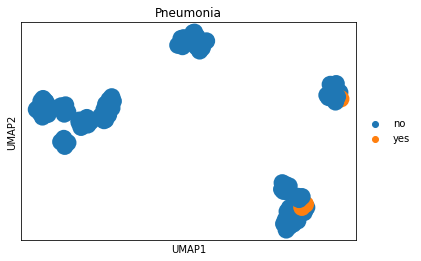

In [11]:
# now we can use the extracted entities from medcat for ehrapy's tools and various plots
# NOTE: all extracted entities here are only affirmed entities (so negaive diagnoses are not taken into account)
# let's see a few examples
ep.tl.umap(ep_medcat.anndata)
# color by Pneumonia, which might be an extracted entity name
ep.pl.umap(ep_medcat, color="Pneumonia")

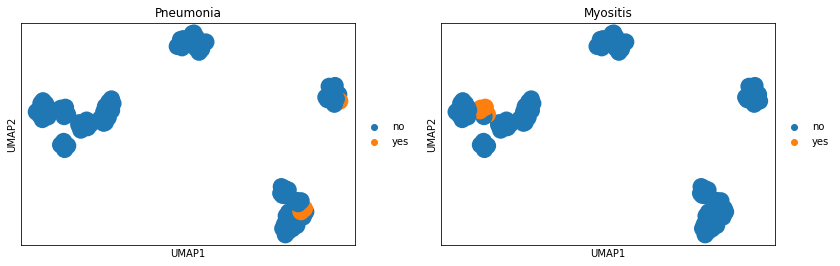

In [12]:
# color by Pneumonia and Myositis, which might be an extracted entity name
ep.pl.umap(ep_medcat, color=["Pneumonia", "Myositis"])

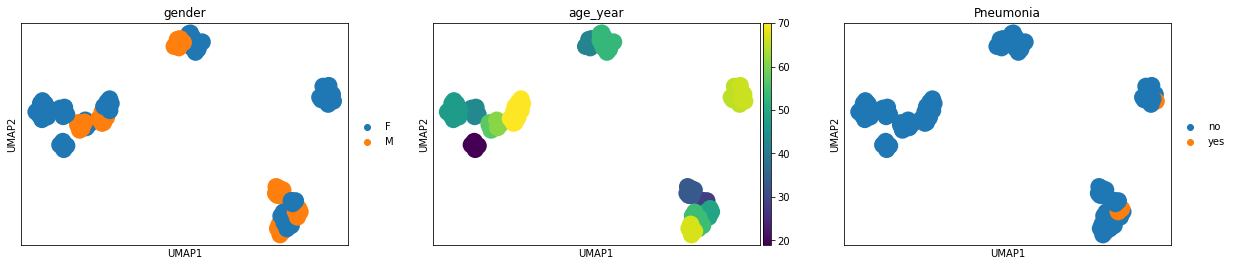

In [13]:
# one can also color by normal columns
ep.pl.umap(ep_medcat, color=["gender", "age_year", "Pneumonia"])

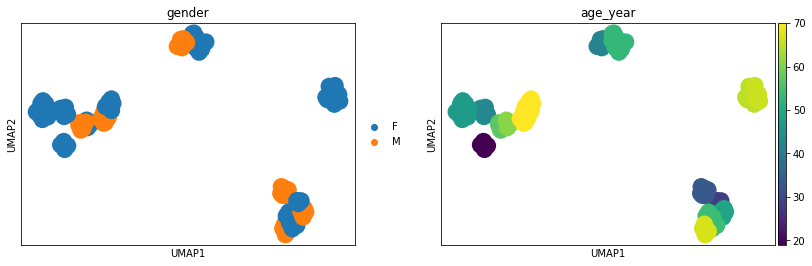

In [15]:
# passing an anndata object instead of a ehrapy MedCAT object will also work but not with extracted entities
ep.pl.umap(ep_medcat.anndata, color=["gender", "age_year"])

Did not found Pneumoni in medcat's extracted entities. Will use best match Pneumonia!

Did not found Myostis in medcat's extracted entities. Will use best match Myositis!

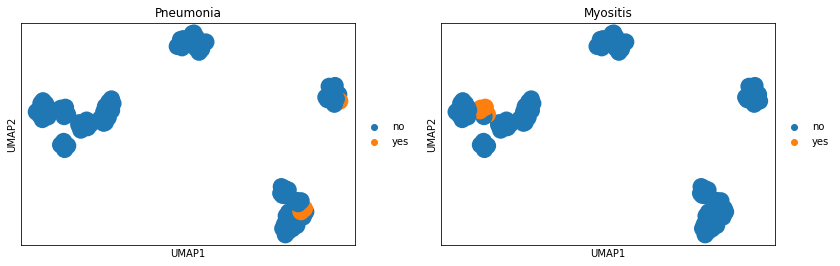

In [16]:
# typos or misspelling are fixed automatically to a certain degree by ehrapy
ep.pl.umap(ep_medcat, color=["Pneumoni", "Myostis"])

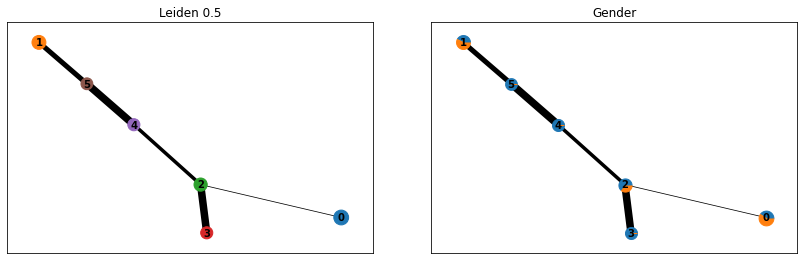

In [17]:
# more complex tooling and plotting is also available
ep.tl.leiden(ep_medcat.anndata, resolution=0.5, key_added="leiden_0_5")
ep.tl.paga(ep_medcat.anndata, groups="leiden_0_5")
# paga currently does not support medcat extracted entities directly (as of ehrapy 0.2.0)
ep.pl.paga(ep_medcat.anndata, color=["leiden_0_5", "gender"], cmap=ep.pl.Colormaps.grey_red.value, title=["Leiden 0.5", "Gender"],)

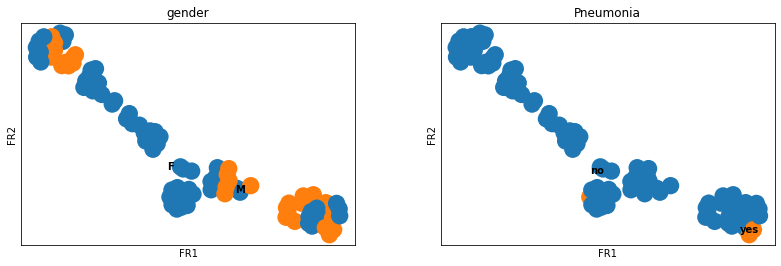

In [19]:
ep.tl.draw_graph(ep_medcat.anndata, init_pos="paga")
ep.pl.draw_graph(ep_medcat, color=["gender", "Pneumonia"], legend_loc="on data")

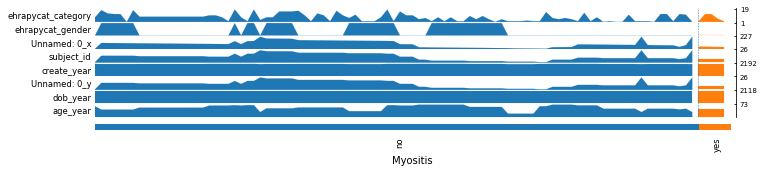

In [20]:
# another example using tracksplot
ep.pl.tracksplot(ep_medcat, list(ep_medcat.anndata.var_names), groupby="Myositis")